# VISUAL STEREO ODOMETRY

### Introduction

<div style="text-align:justify">
Stereo odometry is a technique for estimating the motion of a camera, or a mobile robot equipped with cameras, by analyzing the images captured by two or more cameras placed at different positions. It is a form of visual odometry that uses stereo vision to estimate the relative pose between successive frames of the camera. <br>
</div>

### Algorithm

<div style="text-align:justify">

In the following notebook, we will be using keypoint matches and depth maps to estimate odometry. Hence we will be using the 3D to 3D visual odometry algorithm shown below. <br>

<div style="text-align:center">
    <img src="Images/3d_to_3d_visual_odometry_algorithm.png" style="width: 75%; height: auto;"/>
    <figcaption>Credits: Prof Dr. Bastian Leibe - RWTH</figcaption>
</div>

In this algorithm the 3D point coordinates of corresponding keypoints in two camera frames are assumed to be known. We use this to determine the relative camera pose in the current time step with respect to the previous time step. 

We basically determine the rigid transformation that aligns two sets of 3D points by minimiizing the geometric least squares error. A closed form solution is available for this method. 

Link to Paper (Arun et al. 1987) : [Link](https://ieeexplore.ieee.org/document/4767965)
 
</div>

### Dataset

Link to KITTI Visual Odometry Dataset : [Link](https://www.cvlibs.net/datasets/kitti/eval_odometry.php)

For this project only the following datasets would be needed: 

1. Odometry_data_set (grayscale , 22GB)
2. odometry_data_set (calibration_files , 1MB)
3. odometry_ground_truth_poses (4MB)

**Note:** Change the file paths based on your system to link the code to your dataset directory.  


### Sensor Setup
Link to details on the Sensor Setup : [Link](https://www.cvlibs.net/datasets/kitti/setup.php)


A reference picture of the sensor setup is shown below: 
<div style="text-align:center">
    <img src="Images/sensor_setup.png" style="width: 75%; height: auto;"/>
</div>




In [2]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Extract Ground Truth Trajectory for Sequence 1

In [3]:
gt_poses_raw = pd.read_csv('./dataset/data_odometry_poses/dataset/poses/00.txt' , delimiter=' ', header = None)
print("Shape of ground truth dataframe: " , gt_poses_raw.shape)
gt_poses_raw.head()

Shape of ground truth dataframe:  (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


The ground truth data (sequence 1) has 4541 rows corresponding to the number of image frames and 12 columns corresponding to the flattened 3x4 transformation matrix of the left stereo camera with respect to the global coordinate frame. 

The 3x4 transformation matrix contains a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector (R|t)

We can see this below

In [4]:
print('Starting position:')
start_pose = np.array(gt_poses_raw.iloc[0]).reshape((3,4)).round(2)
start_pose

Starting position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

As this is the start position, the rotation matrix is an identity matrix and the translation vector is a zero vector. 

Similarly the [R|t] transformation matrix can be used to represent the transformation between the current camera coordinate and the world coordinate frame. the world coordinate frame has been taken as the initial position of the camera. 

We now store the ground truth poses in a 3D numpy array 

In [5]:
gt_poses = np.zeros((len(gt_poses_raw),3,4))
for i in range(len(gt_poses_raw)):
    gt_poses[i] = np.array(gt_poses_raw.iloc[i]).reshape((3,4))

In [6]:
gt_poses[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

During the course of this program , we dont need to be concerned with the rotation matrix as the camera rotation effects are implicit in the position of the camera origin over time.

We can extract the position of the camera (t) from the transformation matrix [R|t] in the following way

In [7]:
gt_poses[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

Here we see at the second time step , the value of z coordinate is positive , which means the car has moved forward. (The Z axis of the camera in the camera frame points outward)

In [8]:
%matplotlib inline

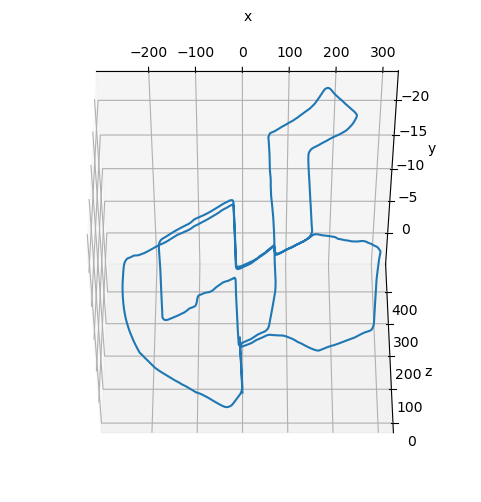

In [9]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt_poses[:, :, 3][:, 0], gt_poses[:, :, 3][:, 1], gt_poses[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

Here we see that the trajectory starts and ends at the same position. Also there seems to be a slight inclination along the y axis during the trajectory indicating the car may have traversed through a hill. 

Test image

In [10]:
test_image = cv2.imread("./dataset/data_odometry_gray/dataset/sequences/00/image_0/000000.png")

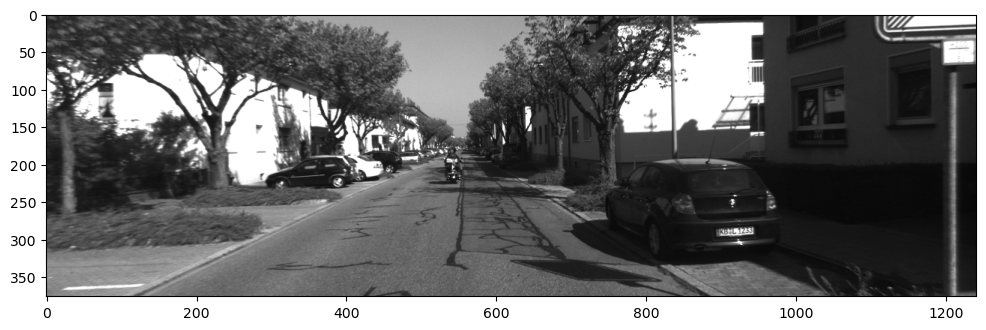

In [11]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_image)

Here we see the initial image from the grayscale camera (left). This is indicated as 000000.png in image 0 in sequence 0. 

Camera Calibration

In [12]:
calib_data = pd.read_csv("./dataset/data_odometry_calib/dataset/sequences/00/calib.txt", delimiter= ' ', header =  None , index_col=0)
calib_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


**Note**: If you do not see the 5th row in the dataframe labeled 'Tr' then the calibration file is incorrect. Please download the following calibration file from this link : [calibration_data](https://www.cvlibs.net/download.php?file=data_odometry_calib.zip) 

The txt file gives us the projection matrices of 4 cameras that have been mounted on the vehicle. P0 and P1 are the left and right grey scale cameras. P2 and P3 are the left and right color cameras. 

the projection matrix for each camera has been flattened out and can be reshaped and extracted. The Tr row is the transformation matrix data for the LIDAR. 

In [13]:
#Extracted Projection matrix for left grey camera
P0 = np.array(calib_data.loc['P0:']).reshape(3,4)
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

**NOTE:** The projection matrix for a camera from the calibration file is **after rectification** with respect to the stereo camera setup.

Usually the projection matrix of a camera takes a 3D point in the global coordinate frame and projects it into the pixel coordinates of that camera,s image frame.

Rectified projection matrix transforms 3D points from a world coordinate system to a rectified image coordinate system. They map points from each camera's coordinate frame onto the coordinate frame of a single image plane. In this case that would be the left camera. 

The rectified projection matrix is used in stereo vision applications to rectify the stereo image pair such that the corresponding epipolar lines are aligned horizontally. This simplifies the task of computing disparities between the stereo images and improves the accuracy of the stereo matching algorithm.



In [16]:
#Decomposition of projection matrix of right greyscale camera

P1 = np.array(calib_data.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix cam 1:' )
print(k1 ,"\n" )
print('Rotation Matrix cam 1:')
print(r1,"\n")
print('Translation Vector cam 1:')
print(t1.round(4),"\n")

#Decomposition of projection matrix of the left greyscale camera

P0 = np.array(calib_data.loc['P0:']).reshape((3,4))
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(P0)
t0 = t0 / t0[3]
print('Intrinsic Matrix cam 0:')
print(k0 ,"\n")
print('Rotation Matrix cam 0:')
print(r0 ,"\n")
print('Translation Vector cam 0:')
print(t0.round(4), "\n")

Intrinsic Matrix cam 1:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 1:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 1:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]] 

Intrinsic Matrix cam 0:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 0:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 0:
[[0.]
 [0.]
 [0.]
 [1.]] 



In [19]:

# Get the rotation and translation vector of right camera in the form [R|t]
Rt_cam1 = np.hstack([r1,t1[:3]]).round(4)
print("Transformation Matrix Camera 1")
print(Rt_cam1,"\n")
#Extract translation vector 
print("Translation vector Camera 1")
origin = np.array([0,0,0,1])
Rt_cam1.dot(origin).round(4).reshape(-1,1)

Transformation Matrix Camera 1
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]] 

Translation vector Camera 1


array([[0.5372],
       [0.    ],
       [0.    ]])

The positive value (+0.54) in the translation vector of the right camera shows that the world coordinate is the left camera. 

### Dataset Handler

A dataset handler will make the data from our dataset more accesible. 

**Note:** It is important to tell numpy to decode the velodyne binaries as float32 as by default it decodes to float64 and thus the decoded information would be incorrect. 